In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, KFold


from imblearn.over_sampling import SMOTE
import time


In [2]:
df = pd.read_csv('Churn-rate.csv')

In [3]:
df.shape

(7043, 21)

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [7]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


# Insights -



1.   SeniorCitizen:

*  The data indicates that 16.21% of the customers are senior citizens. This can help us understand if SeniorCitizens in our data have different churn pattern.

2.   tenure:
* The average tenure of customers is approximately 32.37 months, with a standard deviation of 24.56 months. This indicates a high variability in the duration of customer tenures

* The median tenure (50th percentile) is 29 months, indicating that half of the customers have been with the company for less than 29 months.

3.   MonthlyCharges:
*  The average monthly charge is approximately $$64.76, with a standard deviation of 30.09 $.
*  The median monthly charge (50th percentile) is $70.35, indicating that half of the customers pay less than $70.35 per month.


In [9]:
df["TotalCharges"] = (pd.to_numeric(df["TotalCharges"],errors="coerce"))
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Handeling values in tenure column that are empty

In [10]:
df[df['tenure'] == 0].index


Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')

In [11]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

In [12]:
for i in df.columns[1:]:
    if df[i].dtype == "object":
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes' 'No phone service']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['No' 'Yes' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


replacing -No phone service,No internet service with No

In [13]:
cols = ["OnlineSecurity","OnlineBackup","DeviceProtection",
        "TechSupport","StreamingTV","StreamingMovies"]

for i in cols:
    df[i].replace("No internet service","No",inplace=True)

df["MultipleLines"].replace("No phone service","No",inplace=True)

In [14]:
for i in df.columns[1:]:
    if df[i].dtype == "object":
        print(i,df[i].value_counts().index.values)

gender ['Male' 'Female']
Partner ['No' 'Yes']
Dependents ['No' 'Yes']
PhoneService ['Yes' 'No']
MultipleLines ['No' 'Yes']
InternetService ['Fiber optic' 'DSL' 'No']
OnlineSecurity ['No' 'Yes']
OnlineBackup ['No' 'Yes']
DeviceProtection ['No' 'Yes']
TechSupport ['No' 'Yes']
StreamingTV ['No' 'Yes']
StreamingMovies ['No' 'Yes']
Contract ['Month-to-month' 'Two year' 'One year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


In [15]:
df.drop("customerID",axis="columns",inplace=True)


In [16]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

# **EDA**

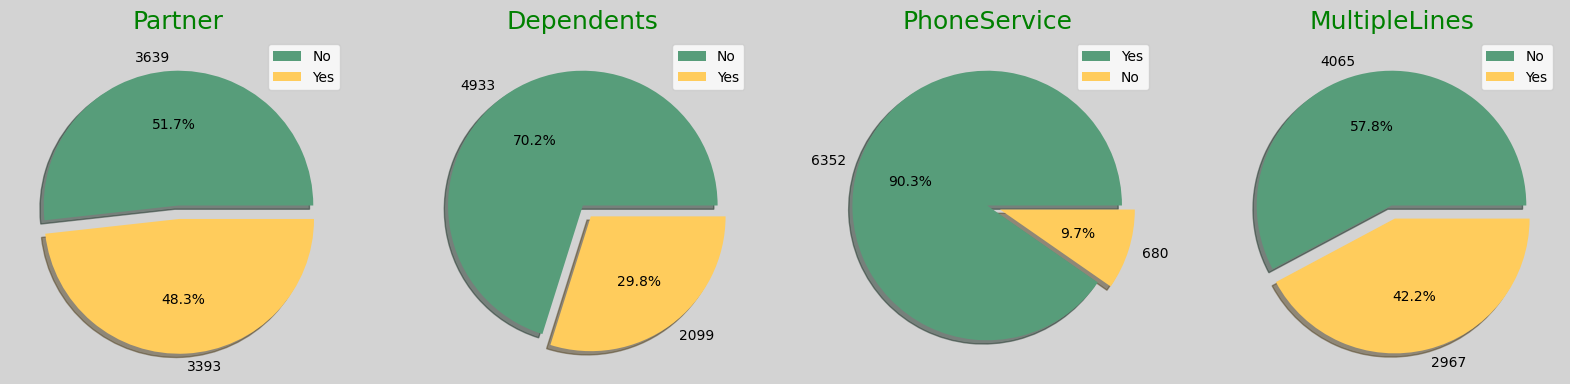

In [17]:
categ_columns = df.select_dtypes("object").columns[1:-1]

fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[:4]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.values,autopct="%1.1f%%",
           explode=[0,0.1],shadow=True,colors=['#579D7A', '#FFCC5C'])
    ax.set_title(column,color="green",size=18)
    ax.legend(data.index)


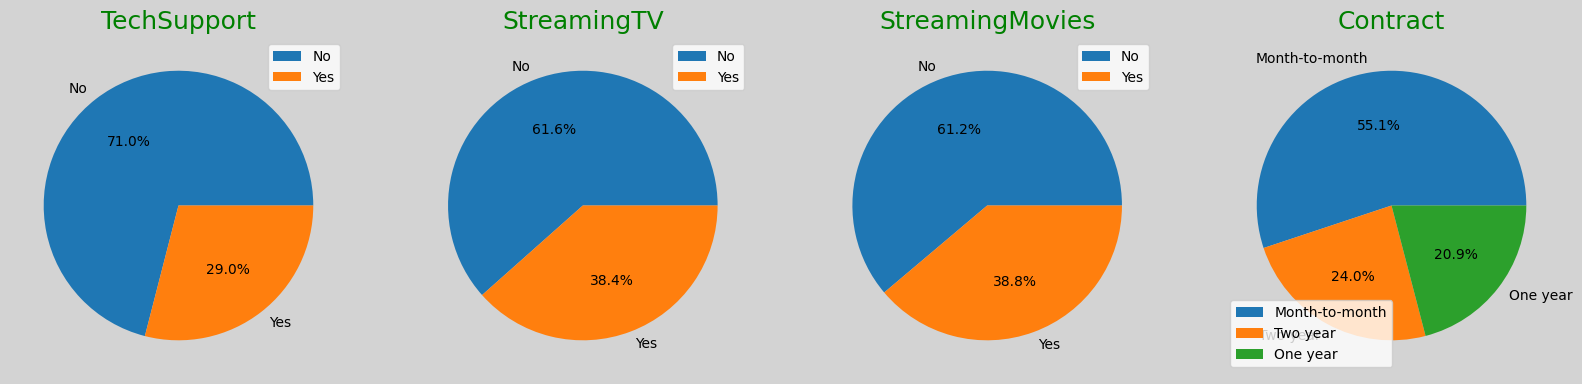

In [18]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create subplots with the alternate color palette
fig, axes = plt.subplots(1, 4, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[8:12]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.index, autopct="%1.1f%%", colors=colors)
    ax.set_title(column, color="green", size=18)
    ax.legend(data.index)

plt.show()


In [19]:
categ_columns

Index(['Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

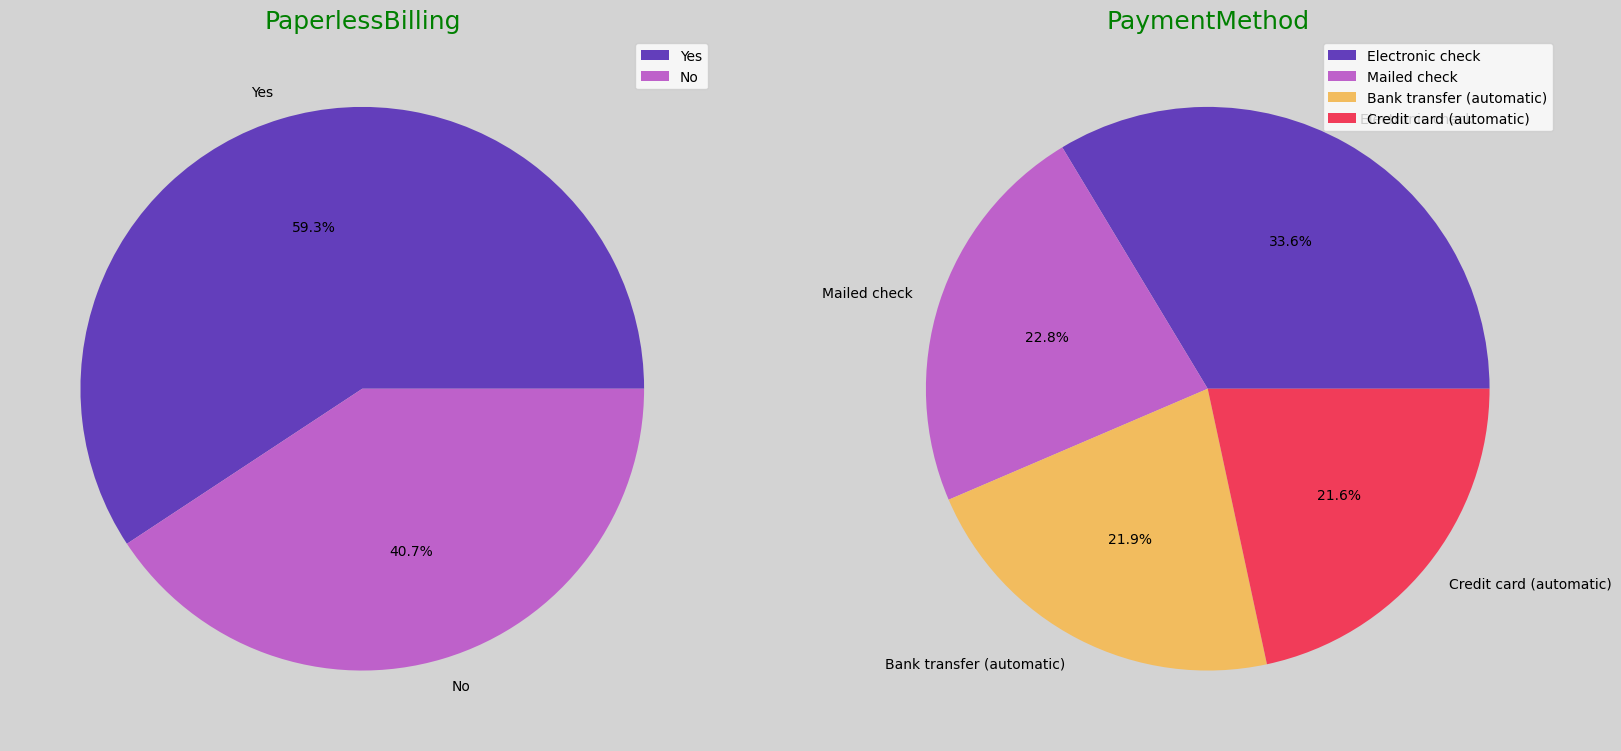

In [20]:
colors = ['#633EBB', '#BE61CA', '#F2BC5E', '#F13C59']

# Create subplots with the alternate color palette
fig, axes = plt.subplots(1, 2, figsize=(20, 12), facecolor="lightgray")

for i, column in enumerate(categ_columns[12:]):
    ax = axes[i]
    data = df[column].value_counts()
    ax.pie(data, labels=data.index, autopct="%1.1f%%", colors=colors)
    ax.set_title(column, color="green", size=18)
    ax.legend(data.index)

plt.show()


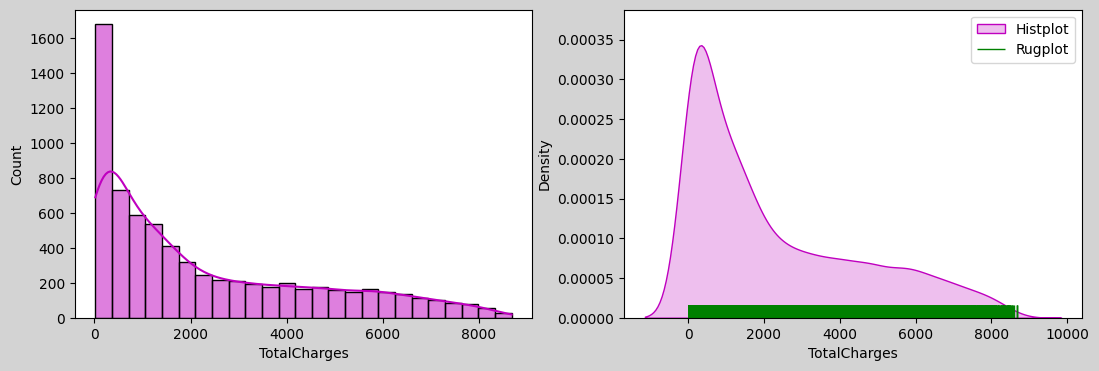

In [21]:
fig , ax = plt.subplots(1,2, figsize = (13,4), facecolor = 'lightgray')

sns.histplot(df['TotalCharges'], color = 'm', ax = ax[0], kde = True)
sns.kdeplot(df['TotalCharges'], fill = True, color = 'm', ax = ax[1])
sns.rugplot(df['TotalCharges'], height = 0.04, color = 'g', ax = ax[1])
ax[1].legend(['Histplot', 'Rugplot'])
plt.show()

(-1.099997566543586,
 1.0999996259728404,
 -1.0999953926151114,
 1.0999997806007196)

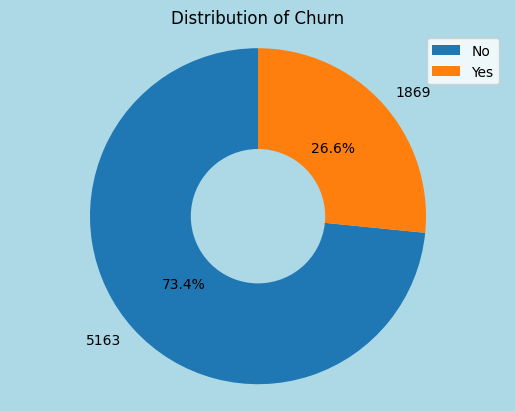

In [23]:
fig, ax = plt.subplots(facecolor="lightblue")
data = df["Churn"].value_counts()
ax.pie(data,autopct='%1.1f%%', startangle=90,labels=data.values)
ax.legend(data.index)
ax.set_title("Distribution of Churn")
centre_circle = plt.Circle((0,0),0.4,fc='lightblue')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')

<Axes: ylabel='Churn'>

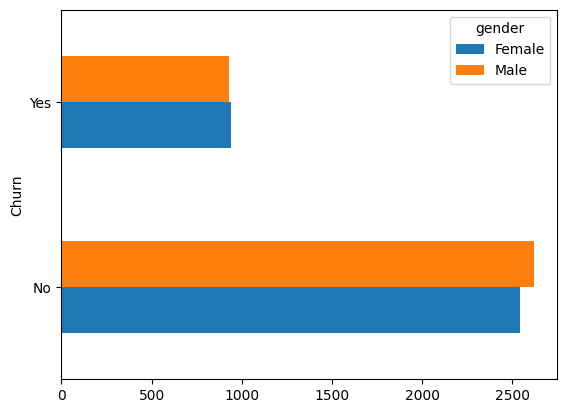

In [24]:
pd.crosstab(df["Churn"],df["gender"]).plot(kind="barh")


[Text(0.5, 0, 'Count')]

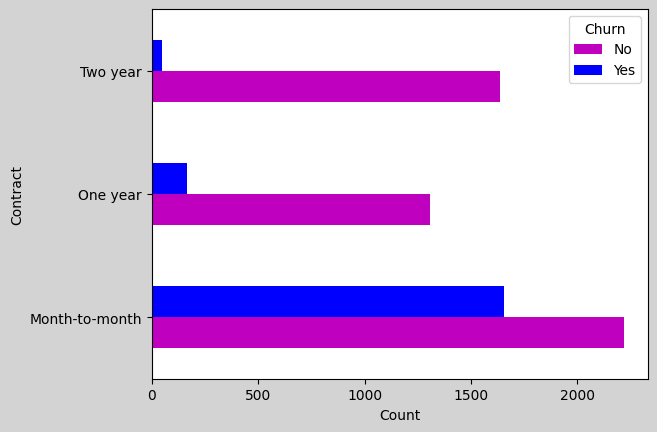

In [25]:
fig , ax = plt.subplots(facecolor="lightgray")
pd.crosstab(df["Contract"],df["Churn"]).plot(kind="barh",color=["m","b"],ax=ax)
ax.set(xlabel="Count")

[Text(0.5, 0, 'Count')]

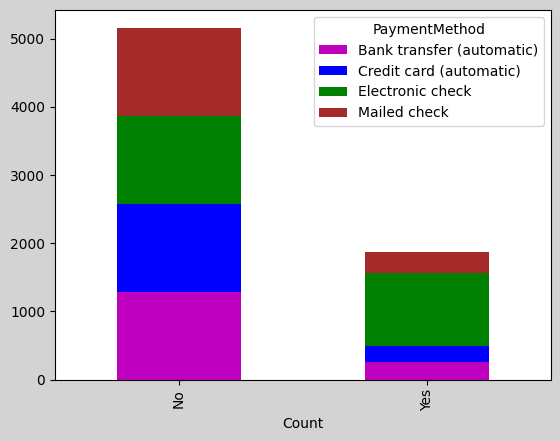

In [26]:
fig , ax = plt.subplots(facecolor="lightgray")
pd.crosstab(df["Churn"],df["PaymentMethod"]).plot(kind="bar",color=["m","b","green","brown"],ax=ax,stacked=True,)
ax.set(xlabel="Count")

Text(0.5, 0.98, 'Distribution of Tenure')

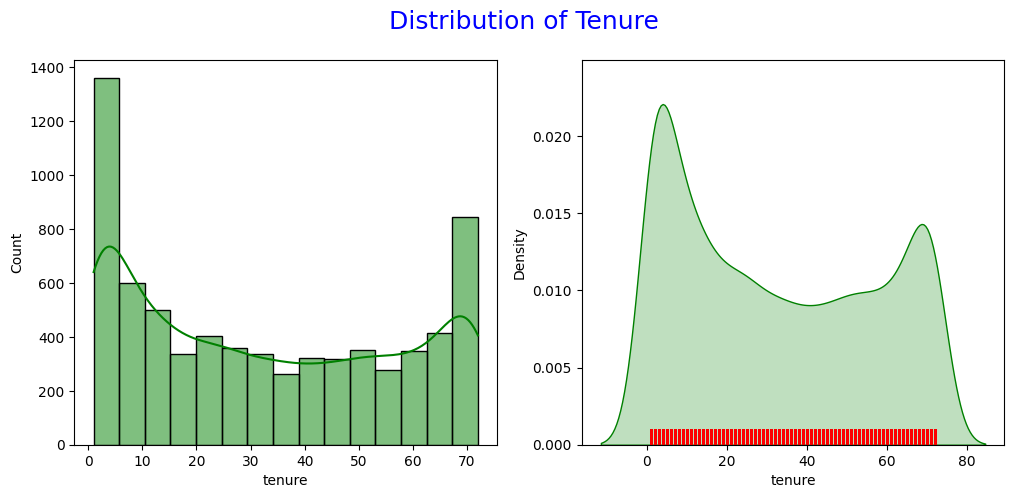

In [27]:
fig, ax = plt.subplots(1,2,figsize = (12,5))

sns.histplot(df['tenure'], kde = True, color = 'g', ax = ax[0])
sns.kdeplot(df['tenure'], color = 'g', ax = ax[1], fill = True)
sns.rugplot(df['tenure'], color = 'r', height = 0.04)

fig.suptitle("Distribution of Tenure",color="blue",size=18)

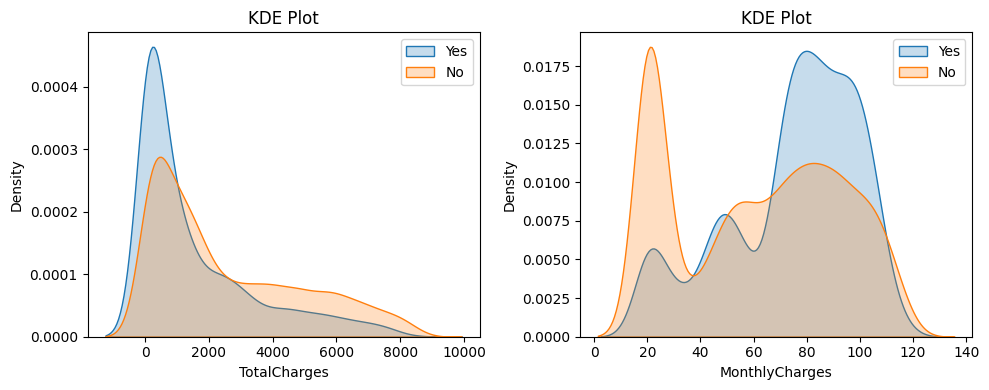

In [28]:
fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.kdeplot(df["TotalCharges"][df["Churn"] == "Yes"],fill=True,ax=ax[0])
sns.kdeplot(df["TotalCharges"][df["Churn"] == "No"],fill=True,ax=ax[0])
ax[0].legend(["Yes","No"])
ax[0].set_title("KDE Plot");

sns.kdeplot(df["MonthlyCharges"][df["Churn"] == "Yes"],fill=True,ax=ax[1])
sns.kdeplot(df["MonthlyCharges"][df["Churn"] == "No"],fill=True,ax=ax[1])
ax[1].legend(["Yes","No"])
ax[1].set_title("KDE Plot")
fig.tight_layout(h_pad=2)

It is observed that customers with monthly charges ranging from $$0 to $40 have a low churn rate.

In [29]:
categorical = df.select_dtypes('object')

In [30]:
categorical.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,Yes,No,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,No,No,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [31]:
encoder = OrdinalEncoder().fit(categorical)

encoded = encoder.transform(categorical)

In [32]:
number = df.select_dtypes("number").reset_index(drop=True)


In [33]:
cate = pd.DataFrame(encoded.astype("int64"),columns=categorical.columns).reset_index(drop=True)


In [34]:
df_final = pd.concat([number,cate],axis=1)
df_final.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,1,29.85,29.85,0,1,0,0,0,0,0,1,0,0,0,0,0,1,2,0
1,0,34,56.95,1889.50,1,0,0,1,0,0,1,0,1,0,0,0,1,0,3,0
2,0,2,53.85,108.15,1,0,0,1,0,0,1,1,0,0,0,0,0,1,3,1
3,0,45,42.30,1840.75,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0
4,0,2,70.70,151.65,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [35]:
scaler = StandardScaler()

df_final[["tenure","MonthlyCharges","TotalCharges"]] = scaler.fit_transform(df_final[["tenure","MonthlyCharges","TotalCharges"]])

In [36]:
X = df_final.drop("Churn",axis="columns")
Y = df_final["Churn"]

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=5, stratify=Y)

In [38]:
y_train.value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

There data is imbalanced. To address this we will be using SMOTE (Synthetic Minority Over-sampling Technique).

To know more about what SMOTE actually is -https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [39]:
smote = SMOTE(random_state = 0)

x_train_res, y_train_res = smote.fit_resample(x_train,y_train)


In [40]:
y_train_res.value_counts()

Churn
0    4130
1    4130
Name: count, dtype: int64

In [56]:
def parameter_finder(model, parameters, x_train_res, y_train_res, x_test, y_test):
    start = time.time()

    grid = GridSearchCV(model,
                        param_grid=parameters,
                        refit=True,
                        cv=KFold(shuffle=True, random_state=1),
                        n_jobs=-1)
    grid_fit = grid.fit(x_train_res, y_train_res)
    best = grid_fit.best_estimator_
    y_pred = best.predict(x_test)

    train_score = best.score(x_train_res, y_train_res)
    test_score = best.score(x_test, y_test)
    F1_score = f1_score(y_test, y_pred).round(2)

    model_name = str(model).split('(')[0]

    end = time.time()
    takes_time = np.round(end - start, 2)

    print(f"The best parameters for {model_name} model are: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"F1 score is {F1_score:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {takes_time:0.2f}")

    return best, train_score, test_score, F1_score, y_pred, takes_time


In [65]:
dt_clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model, train_dt, test_dt, f1_dt, pred_dt, time_dt = parameter_finder(dt_clf, param_grid, x_train_res, y_train_res, x_test, y_test)


The best parameters for DecisionTreeClassifier model are: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
--------------------
(R2 score) in the training set is 78.87% for DecisionTreeClassifier model.
(R2 score) in the testing set is 74.56% for DecisionTreeClassifier model.
F1 score is 0.61 for DecisionTreeClassifier model.
--------------------
Runtime of the program is: 7.25


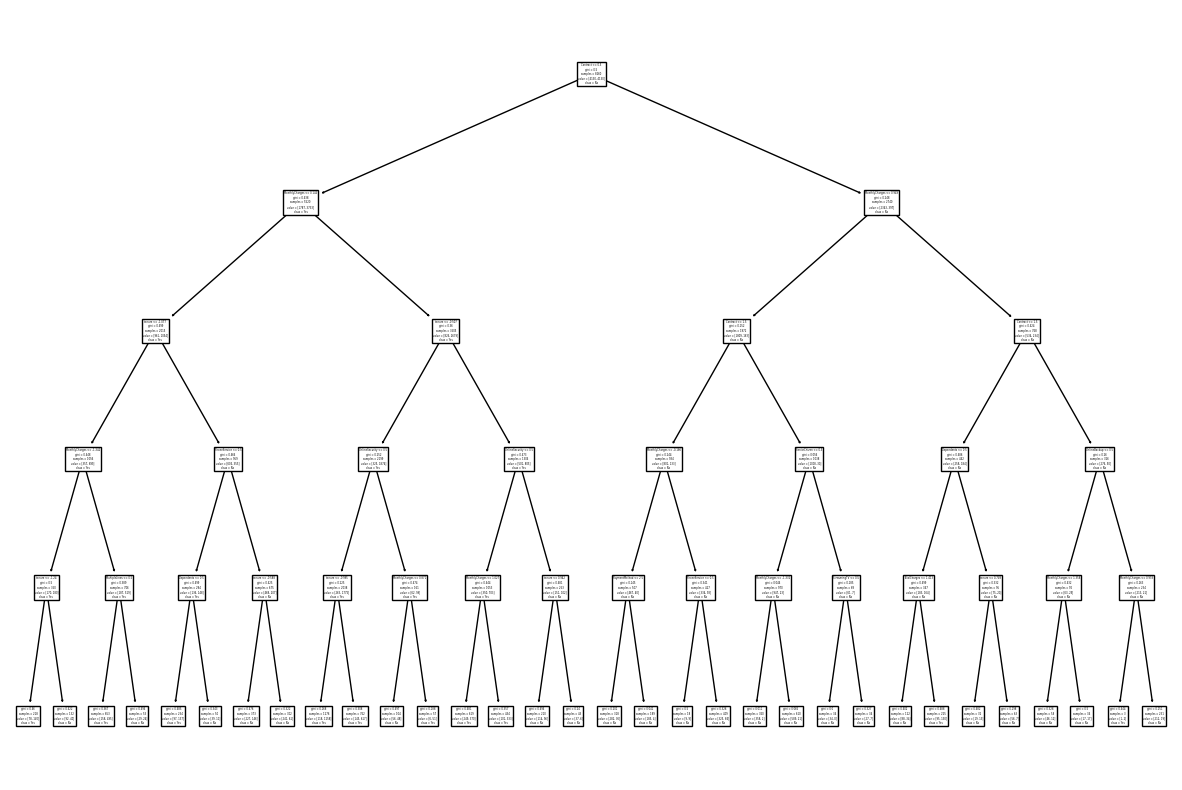

In [66]:
plt.figure(figsize=(15, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()

In [68]:
rf = RandomForestClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 25, 60, 100],
              'max_depth': [3, 5, 7, 8],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5]
              }

rf_model, train_rf, test_rf, f1_rf, pred_rf, time_rf = parameter_finder(rf, param_grid, x_train_res, y_train_res, x_test, y_test)

The best parameters for RandomForestClassifier model are: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 60}
--------------------
(R2 score) in the training set is 83.97% for RandomForestClassifier model.
(R2 score) in the testing set is 76.69% for RandomForestClassifier model.
F1 score is 0.63 for RandomForestClassifier model.
--------------------
Runtime of the program is: 280.05
